#### CSC 180 Intelligent Systems 

#### Dr. Haiquan Chen, Dept of Computer Scicence

#### California State University, Sacramento



## Lab 5: Hyper-parameter Tuning and Dropout


### Helpful Functions for Tensorflow (Little Gems)

The following functions will be used with TensorFlow to help preprocess the data.  They allow you to build the feature vector for a neural network. 

* Predictors/Inputs 
    * Fill any missing inputs with the median for that column.  Use **missing_median**.
    * Encode textual/categorical values with **encode_text_dummy**.
    * Encode numeric values with **encode_numeric_zscore**.
* Output
    * Discard rows with missing outputs.
    * Encode textual/categorical values with **encode_text_index**.
    * Do not encode output numeric values.
* Produce final feature vectors (x) and expected output (y) with **to_xy**.

In [6]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


## "Hyper"-parameters vs "regular" parameters

"Hyperparameters" are not changed when the neural network trains. They are design choices. You, the network designer, must define the "hyperparameters". 

Neural network weights learned from data are known as "regular" parameter. The neural network learns "regular" parameters during neural network training. 

### Layer type, Number of Hidden Layers, and Neuron Counts

How many layers should you have? How many neurons are on each layer? What activation function and layer type should you use? Generally, the number of neurons on each layer will gradually decrease as you traverse the model from input to output. This configuration gives the neural network a somewhat triangular or trapezoid. 

There are many different [types of layer](https://keras.io/layers/core/) in Keras, listed here:

* **Activation** - You can also add activation functions as layers.  Using the activation layer is the same as specifying the activation function as part of a Dense (or other) layer type.
* **Dense** - The original neural network layer type. In this layer type, every neuron connects to the next layer. The input vector is one-dimensional, and placing specific inputs next does not affect each other. 
* **Dropout** - Dropout consists of randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting. Dropout only occurs during training.
* **Flatten** - Flattens the input to 1D and does not affect the batch size.
* **Input** - A Keras tensor is a tensor object from the underlying back end (Theano, TensorFlow, or CNTK), which we augment with specific attributes to build a Keras by knowing the inputs and outputs of the model.
* **Lambda** - Wraps arbitrary expression as a Layer object.
* **Masking** - Masks a sequence using a mask value to skip timesteps.
* **Permute** - Permutes the input dimensions according to a given pattern. Useful for tasks such as connecting RNNs and convolutional networks.
* **RepeatVector** - Repeats the input n times.
* **Reshape** - Similar to Numpy reshapes.


### Activation Functions

Activation functions are a choice that you must make for each layer. Generally, you can follow this guideline:
* Hidden Layers - RELU
* Output Layer - Softmax for classification, No activation for regression.

Some of the common activation functions in Keras are listed here:

* **softmax** - Used for multi-class classification.  Ensures all output neurons behave as probabilities and sum to 1.0.
* **elu** - Exponential linear unit.  Exponential Linear Unit or its widely known name ELU is a function that tends to converge cost to zero faster and produce more accurate results. Can produce negative outputs.
* **selu** - Scaled Exponential Linear Unit (SELU), essentially **elu** multiplied by a scaling constant.
* **softplus** - Softplus activation function. $log(exp(x) + 1)$  
* **softsign** Softsign activation function. $x / (abs(x) + 1)$ Similar to tanh, but not widely used.
* **relu** - Very popular neural network activation function.  Used for hidden layers, cannot output negative values. No trainable parameters.
* **tanh** Classic neural network activation function, though often replaced by relu family on modern networks.
* **sigmoid** - Classic neural network activation.  Often used on output layer of a binary classifier.
* **hard_sigmoid** - Less computationally expensive variant of sigmoid.
* **exponential** - Exponential (base e) activation function.
* **linear** - Pass-through activation function. Also known as "no activation," or "identity function" (multiplied x1. 0). 

For more information about Keras activation functions refer to the following:

* [Keras Activation Functions](https://keras.io/activations/)
* [Activation Function Cheat Sheets](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html)


### Regularization: L1, L2, Dropout

Regularizers allow you to apply penalties on layer parameters or layer activity during optimization. They are used to mitigate overfiltting. 

* [Keras Regularization](https://keras.io/regularizers/)
* [Keras Dropout](https://keras.io/layers/core/)

### Batch and Layer Normalization 

* [Keras Batch Normalization](https://keras.io/layers/normalization/)

Batch and layer normalization are two strategies for training neural networks faster and stable.  
* BatchNorm normalizes each feature ```within a batch of samples``` into the same range, 
* LayerNorm normalizes ```all features``` within each sample into the same range.



### Learning rate
Backpropagation is the primary means by which a neural network's weights are determined during training. Backpropagation works by calculating a weight change amount ($v_t$) for every weight($\theta$, theata) in the neural network.  This value is subtracted from every weight by the following equation: 

$ \theta_t = \theta_{t-1} - v_t $


* Too low of a learning rate will usually converge to a good solution; however, the process will be very slow.
* Too high of a learning rate will either fail outright, causing loss occilating, or converge to a higher error.

Common values for learning rate are: 0.1, 0.01, 0.001, etc.


### Batch size

Number of samples per gradient update.  In keras, you may set the batch_size parameter in function fit()

batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.

### Optimizer (the paramter update rule)

https://keras.io/optimizers/

```An optimizer is one of the two arguments required when you compile a Keras model using compile().``` 

```What is the other argument required using compile()? ```

TensorFlow allows the update rule to be set to one of:

* Adagrad
* **Adam**
* Ftrl
* Momentum
* RMSProp
* **SGD**



You can either instantiate an optimizer or you can call it by its name. In the latter case, the default parameters for the optimizer will be used.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(10, input_dim=10, activation='relu'))
model.add(Dense(1))

sgd = optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

#adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='mean_squared_error', optimizer=sgd)

or using all Default Parameters for a Particular Optimizer

In [2]:
# pass optimizer by name: default parameters will be used
model.compile(loss='mean_squared_error', optimizer='sgd')

## A Complete Example:

Epoch 1/1000


c:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 - 1s - loss: 615.6175 - val_loss: 583.1578 - 649ms/epoch - 216ms/step
Epoch 2/1000
3/3 - 0s - loss: 615.1808 - val_loss: 582.5811 - 53ms/epoch - 18ms/step
Epoch 3/1000
3/3 - 0s - loss: 614.5829 - val_loss: 581.9971 - 58ms/epoch - 19ms/step
Epoch 4/1000
3/3 - 0s - loss: 614.0353 - val_loss: 581.3705 - 64ms/epoch - 21ms/step
Epoch 5/1000
3/3 - 0s - loss: 613.4210 - val_loss: 580.7250 - 48ms/epoch - 16ms/step
Epoch 6/1000
3/3 - 0s - loss: 612.7612 - val_loss: 579.9991 - 61ms/epoch - 20ms/step
Epoch 7/1000
3/3 - 0s - loss: 612.0571 - val_loss: 579.1908 - 55ms/epoch - 18ms/step
Epoch 8/1000
3/3 - 0s - loss: 611.2805 - val_loss: 578.3341 - 42ms/epoch - 14ms/step
Epoch 9/1000
3/3 - 0s - loss: 610.4593 - val_loss: 577.3786 - 66ms/epoch - 22ms/step
Epoch 10/1000
3/3 - 0s - loss: 609.5291 - val_loss: 576.3661 - 44ms/epoch - 15ms/step
Epoch 11/1000
3/3 - 0s - loss: 608.5723 - val_loss: 575.2745 - 63ms/epoch - 21ms/step
Epoch 12/1000
3/3 - 0s - loss: 607.4505 - val_loss: 574.0777 - 57ms/epoch 

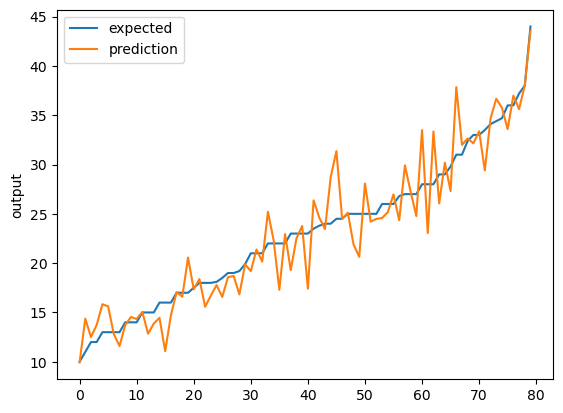

In [7]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

path = "./data/"
preprocess = True

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
encode_text_dummy(df, 'origin')
df.drop('name',1,inplace=True)
if preprocess:
    encode_numeric_zscore(df, 'horsepower')
    encode_numeric_zscore(df, 'weight')
    encode_numeric_zscore(df, 'cylinders')
    encode_numeric_zscore(df, 'displacement')
    encode_numeric_zscore(df, 'acceleration')
    encode_numeric_zscore(df, 'year')

# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], activation='relu'))
 
model.add(Dense(1, activation='relu'))

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=adam)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

# batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 128, callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test)

### Next we vary the optimizer paramters (SGD) and batch size (32) 

Epoch 1/1000
10/10 - 0s - loss: 591.0693 - val_loss: 535.8856 - 430ms/epoch - 43ms/step
Epoch 2/1000
10/10 - 0s - loss: 539.8366 - val_loss: 460.7571 - 68ms/epoch - 7ms/step
Epoch 3/1000
10/10 - 0s - loss: 443.3057 - val_loss: 345.3503 - 51ms/epoch - 5ms/step
Epoch 4/1000
10/10 - 0s - loss: 298.7317 - val_loss: 188.1668 - 58ms/epoch - 6ms/step
Epoch 5/1000
10/10 - 0s - loss: 135.4198 - val_loss: 63.6127 - 71ms/epoch - 7ms/step
Epoch 6/1000
10/10 - 0s - loss: 46.5024 - val_loss: 32.7558 - 72ms/epoch - 7ms/step
Epoch 7/1000
10/10 - 0s - loss: 28.6461 - val_loss: 24.3885 - 68ms/epoch - 7ms/step
Epoch 8/1000
10/10 - 0s - loss: 21.1512 - val_loss: 16.8236 - 54ms/epoch - 5ms/step
Epoch 9/1000
10/10 - 0s - loss: 17.4220 - val_loss: 13.5397 - 64ms/epoch - 6ms/step
Epoch 10/1000
10/10 - 0s - loss: 15.5268 - val_loss: 12.1737 - 67ms/epoch - 7ms/step
Epoch 11/1000
10/10 - 0s - loss: 14.3367 - val_loss: 11.3248 - 61ms/epoch - 6ms/step
Epoch 12/1000
10/10 - 0s - loss: 13.5271 - val_loss: 10.8496 - 

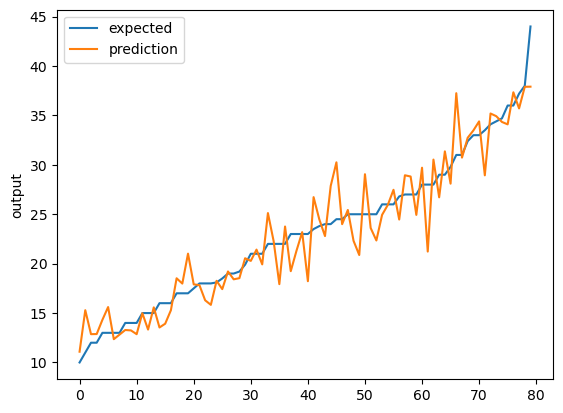

In [8]:
model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], activation='relu'))
 
model.add(Dense(1, activation='relu'))

sgd = optimizers.SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)   # much smaller lr
model.compile(loss='mean_squared_error', optimizer=sgd)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

# batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 32, callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test)



### Dropout Layer  (A dedicated layer for regularization)

A dropout layer can be added between any two hidden layers to reduce overfitting. 

***To create a dropout layer, specify dropout probability.***  The dropout probability indicates the likelihood of a neuron dropping out for every batch during training. Typically this value is 0.1 to 0.5. 

***Actually, a certain percentage of neurons will be masked during each training iteration.  All neurons return after training is complete.*** 

Let's add some dropout


Epoch 1/1000
10/10 - 0s - loss: 614.4294 - val_loss: 571.0382 - 399ms/epoch - 40ms/step
Epoch 2/1000
10/10 - 0s - loss: 575.9645 - val_loss: 506.8411 - 64ms/epoch - 6ms/step
Epoch 3/1000
10/10 - 0s - loss: 486.2440 - val_loss: 392.7767 - 51ms/epoch - 5ms/step
Epoch 4/1000
10/10 - 0s - loss: 341.1682 - val_loss: 232.3412 - 48ms/epoch - 5ms/step
Epoch 5/1000
10/10 - 0s - loss: 170.8583 - val_loss: 89.6745 - 71ms/epoch - 7ms/step
Epoch 6/1000
10/10 - 0s - loss: 64.3438 - val_loss: 45.5146 - 76ms/epoch - 8ms/step
Epoch 7/1000
10/10 - 0s - loss: 41.6726 - val_loss: 38.3715 - 72ms/epoch - 7ms/step
Epoch 8/1000
10/10 - 0s - loss: 34.6982 - val_loss: 25.3211 - 77ms/epoch - 8ms/step
Epoch 9/1000
10/10 - 0s - loss: 24.9340 - val_loss: 19.3312 - 74ms/epoch - 7ms/step
Epoch 10/1000
10/10 - 0s - loss: 21.6809 - val_loss: 17.4550 - 61ms/epoch - 6ms/step
Epoch 11/1000
10/10 - 0s - loss: 21.5496 - val_loss: 16.1394 - 67ms/epoch - 7ms/step
Epoch 12/1000
10/10 - 0s - loss: 19.3598 - val_loss: 14.9748 - 

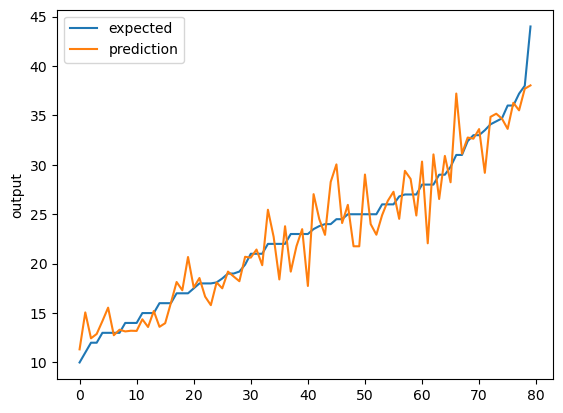

In [9]:
from tensorflow.keras.layers import Dense, Activation, Dropout


model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu')) #changed to 100

model.add(Dropout(0.1)) 

model.add(Dense(1, activation='relu'))


sgd = optimizers.SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)   # much smaller lr
model.compile(loss='mean_squared_error', optimizer=sgd)


monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

# batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 32, callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test)



### References:

* [Google Colab](https://colab.research.google.com/) - Free web based platform that includes Python, Juypter Notebooks, and TensorFlow with free GPU support.  No setup needed.
* [IBM Cognitive Class Labs](https://www.datascientistworkbench.com) - Free web based platform that includes Python, Juypter Notebooks, and TensorFlow.  No setup needed.
* [Python Anaconda](https://www.continuum.io/downloads) - Python distribution that includes many data science packages, such as Numpy, Scipy, Scikit-Learn, Pandas, and much more.
* [TensorFlow](https://www.tensorflow.org/) - Google's mathematics package for deep learning.
* [Kaggle](https://www.kaggle.com/) - Competitive data science.  Good source of sample data.
* T81-558: Applications of Deep Neural Networks. Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/)